# Gaussian Random Fields as priors on unstructured meshes
**i.e. Inversions in Hilbert space / infinite dimensional Bayesian inference**

One thing we'd (I'd) like in inverse problems in Earth Sciences is to encode the prior better. A way to do this for Gaussian knowledge is using Gaussian random fields (GRF). Gaussians are arguably one of the more popular priors, even if they are not always the best choice. 

GRF's have a few advantages over discrete Gaussian priors which make them particularly interesting for inverse problems:
- GRF's allow us te encode non-stationary behaviour easily;
- GRF's make the inverse problem **mesh-independent**;
- Markov chains over Hilbert space inverse problems **do not suffer from the curse of dimensionality** (at least not in the same way as their discrete counterparts).

A typical discrete prior distribution has for every parameter $m_i$ a marginal distribution, and for the complete set of parameters $\mathbf{m}$ the total prior distribution. In contrast, a Gaussian random field (or process) is a continuous measure of knowledge on a function space. This means, it says something about a function $u(\mathbf{x})$ living on some domain $\Omega$. **Effectively, we now invert in the Hilbert space on domain $\Omega$.**

The GRF is characterised by $\mathcal{N}(\mu_0(\mathbf{x}), \mathcal{C})$. Here, $\mu_0(\mathbf{x})$ is the mean function, and $\mathcal{C}$ the covariance operator. The operator $\mathcal{C}$ is a real beast, and it is __the__ thing to understand about GRF's. It defines the dispersive properties of the random process, i.e. the direction and strength of correlations.

Note: *I'm not a mathematician, nor well-versed in FEM literature. Therefore, there are bound to be a errors in this notebook. Please consult the references below for rigorous mathematical details. However, I do find that in this notebook the actual content is a little less convoluted for the average joe, MSc.*

## References

> [**(1)** Bui-Thanh, T.; Ghattas, O.; Martin, J. & Stadler, G. A computational framework for infinite-dimensional Bayesian inverse problems, Part I: The linearized case, with application to global seismic inversion SIAM Journal on Scientific Computing, SIAM, 2013, 35, A2494-A2523](https://epubs.siam.org/doi/abs/10.1137/12089586X)

## Misfit function / Cameron-Martin norm 
Now before we dive into $\mathcal{C}$ I'd like to introduce the characteristic function of a GRF. It is defined as:
$$
\begin{align}
\chi(u) :=& \frac{1}{2} \left|\left| \left( u - \mu_0\right) \right|\right|^2_{\mathcal{C}}\\
=& \frac{1}{2} \left|\left| \mathcal{C}^{-\frac{1}{2}}\left( u - \mu_0\right) \right|\right|^2_{L^2\left( \Omega \right)}\\
=& \frac{1}{2}\langle \mathcal{C}^{-\frac{1}{2}} \left( u - \mu_0\right) , \mathcal{C}^{-\frac{1}{2}} \left( u - \mu_0\right) \rangle\\
=& \frac{1}{2}\int_\Omega \left( \mathcal{C}^{-\frac{1}{2}} \left( u - \mu_0\right)\right)^T \mathcal{C}^{-\frac{1}{2}} \left( u - \mu_0\right) d\mathbf{x}\\
=& \frac{1}{2} \int_\Omega \left( u - \mu_0 \right)^T (\mathcal{C}^{-\frac{1}{2}})^T \mathcal{C}^{-\frac{1}{2}} \left( u - \mu_0\right) d\mathbf{x}\\
=& \frac{1}{2}\int_\Omega \left( u - \mu_0\right)^T \mathcal{C}^{-\frac{1}{2}} \mathcal{C}^{-\frac{1}{2}} \left( u - \mu_0\right) d\mathbf{x}\\
=& \frac{1}{2}\int_\Omega \left( u - \mu_0\right)^T \mathcal{C}^{-1} \left( u - \mu_0\right) d\mathbf{x}\\
\end{align}
$$
This thing is also called the Cameron-Martin norm (of the function $\left[u - \mu_0\right]$) associated with $\mathcal{C}$. The mean function has no role in the Cameron-Martin norm, only in the misfit function.

## The covariance operator

Choosing an appriopriate $\mathcal{C}$ is serious business. It has to satisfy a few properties to make the mathematics work out. For starters, because $\mathcal{C}$ is a measure, it needs to be positive definite. It should also be self-adjoint. Additionaly, it's covariance functions (we'll get to these) need to be bounded. There is a bunch more, described in [1], [2], and most completely in [3]. We'll analyse a few below.

#### Non-stationary dispersive operator
One nice choice of $\mathcal{C}$ is $\mathcal{C} = \mathcal{A}^{-2}$, where $\mathcal{A}$ is a Laplacian like operator. 
The Laplacian-like operator used in [1] and this notebook is:
$$
\begin{align}
    \mathcal{A} = -\alpha \nabla \cdot \left(  \Theta \nabla  \right) + \alpha
\end{align}
$$
with the Neumann boundary condition on the field u:
$$
\begin{align}
    \alpha \left(  \Theta \nabla u \right) \cdot \mathbf{n} = 0, \quad \text{on } \partial \Omega.
\end{align}
$$
The nice property is that we can allow $\Theta$ to be an non-stationary operator that encodes spatially varying dispersion and anisotropy.  A great example $\Theta(\mathbf{x})$ for velocity distribution prior is given in [1], which has been replicated in this notebook (further down).

With the chosen $\mathcal{A}$ the covariance operator becomes:
$$
\begin{align}
    \mathcal{C} =& (-\alpha \nabla \cdot \left(  \Theta \nabla  \right) + \alpha)^{-2}.
\end{align}
$$
The resulting operator is stable for at most 3 spatial dimensions, as demonstrated in [2]. 

#### Stable operator for arbitrary dimension
Another operator that is not implemented in this notebook is the generalization of $\mathcal{A}_1$ in the case that $\Theta = \mathbf{I}$, as proposed in [2]:
$$
\begin{align}
    \mathcal{C} =& \alpha^{-1} \left(I - ∆\right)^{-s}\\
                =& \alpha^{-1} \mathcal{A}^{-s}
\end{align}
$$
with the Neumann boundary condition on the field u:
$$
\begin{align}
    \frac{\partial u}{\partial n} = 0, \quad \text{on } \partial \Omega.
\end{align}
$$
These operators have the nice property the the measure is well behaved as long as $s > d/2$, with $d$ the spatial dimension. However, in this operator there is no non-stationary component.

## The PDE associated with the GRF

The PDE associated with the covariance operator $\mathcal{C}$ from [1] is given as:
$$
    \mathcal{A}u = f
$$
where f is a arbitrary forcing term. The boundary condition is still the same:
$$
\begin{align}
    \alpha \left(  \Theta \nabla u \right) \cdot \mathbf{n} = 0, \quad \text{on } \partial \Omega.
\end{align}
$$

Solving this PDE for different forcing terms is very insightful. By applying Delta function we can for example compute the covariance functions. By applying Gaussian white noise as the forcing, we can generate samples from the distribution. Both are demonstrated in this notebook.

## Eigenfunctions and Eigenvalues 

**To be written**

Decaying, minimal variance length, spectral decomposition, FEM discretization, infinite eigenfunctions.

## What we'll need

We'll be solving PDE's using finite elements on some arbitrary domain in at most $\mathbb{R}^3$. We use the FEM package *Fenics* and its associated meshing package *mshr*. Additionally, we'll import SciPy for sparse matrix algebra, NumPy for random number generation and linear algebra, and Matplotlib for plotting.

In [1]:
# FEM tools
import fenics
import mshr

# Linear algebra tools
import numpy as np
from scipy.sparse import csr_matrix, csc_matrix
from scipy import linalg
from scipy.sparse.linalg import spsolve

# Plotting tools
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from IPython import display

# A function to extract mesh coordinates into triangulation objects
def mesh2triang(mesh):
    xy = mesh.coordinates()
    return tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())

### Creating the domain and mesh

To start, we'll use mshr to create a circular domain and mesh it rather fine.

Text(0, 0.5, 'y')

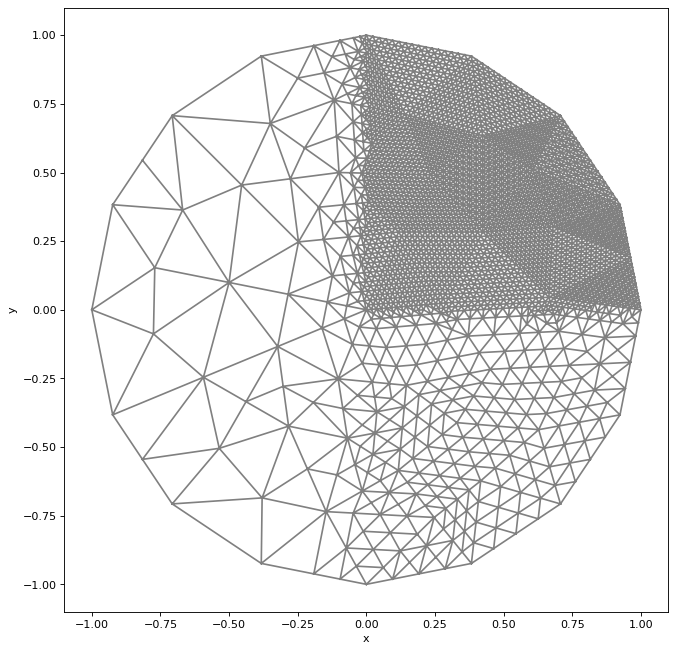

In [82]:
# Create mesh and plot
domain = mshr.Circle(fenics.Point(0, 0), 1)
mesh = mshr.generate_mesh(domain, 5)

cell_markers = mshr.dolfin.MeshFunction("bool", mesh, 2)
cell_markers.set_all(False)
for cell in fenics.cells(mesh):
    coor_midpoint = cell.midpoint()
    if coor_midpoint[0] > 0:
        cell_markers[cell] = True
mesh = fenics.refine(mesh, cell_markers)
cell_markers = mshr.dolfin.MeshFunction("bool", mesh, 2)
cell_markers.set_all(False)
for cell in fenics.cells(mesh):
    coor_midpoint = cell.midpoint()
    if coor_midpoint[0] > 0:
        cell_markers[cell] = True
mesh = fenics.refine(mesh, cell_markers)

cell_markers = mshr.dolfin.MeshFunction("bool", mesh, 2)
cell_markers.set_all(False)
for cell in fenics.cells(mesh):
    coor_midpoint = cell.midpoint()
    if coor_midpoint[0] > 0 and coor_midpoint[1] > 0:
        cell_markers[cell] = True
mesh = fenics.refine(mesh, cell_markers)
cell_markers = mshr.dolfin.MeshFunction("bool", mesh, 2)
cell_markers.set_all(False)
for cell in fenics.cells(mesh):
    coor_midpoint = cell.midpoint()
    if coor_midpoint[0] > 0 and coor_midpoint[1] > 0:
        cell_markers[cell] = True
mesh = fenics.refine(mesh, cell_markers)

fig = plt.figure(figsize=(10, 10), dpi=80, facecolor="w", edgecolor="k")
lines = fenics.plot(mesh)
plt.xlabel("x")
plt.ylabel("y")

### Variational form

To solve the elliptic PDE we need to create its variational form. For the discussed PDE it is given as:

The PDE associated with the covariance operator $\mathcal{C}$ from [1] is given as:
$$
    \alpha \int_\Omega \left(  \Theta \nabla u \right) \cdot \nabla v+ \alpha \, u \, v \, dx = \int_\Omega f \, v \, dx
$$
with trial function $u$ and test function $v$. Identifying the linear and bilinear forms as respectively the RHS and LHS make this expression easily solvable using Fenics.

We'll start by defining the function space and test/trial functions to live in this space. This directly defines the shape functions used in the FEM solve.

In [83]:
V = fenics.FunctionSpace(mesh, "CG", 1)
u = fenics.TrialFunction(V)
v = fenics.TestFunction(V)

Next, we enter expressions for the linear and bilinear form. $\Theta$ is taken from [1], but rescaled for the unit circle, and only 2 dimensional.

In [84]:
# Create the linear operator
theta = fenics.Expression(
    (
        (
            "Beta*(1 - x[0] * x[0] * (1-Theta) * ( 2 * pow((x[0] * x[0] + x[1] * x[1]),0.5) - (x[0] * x[0] + x[1] * x[1])) / (x[0] * x[0] + x[1] * x[1]))",
            "Beta*( - x[0] * x[1] * (1-Theta) * ( 2 * pow((x[0] * x[0] + x[1] * x[1]),0.5) - (x[0] * x[0] + x[1] * x[1])) / (x[0] * x[0] + x[1] * x[1]))",
        ),
        (
            "Beta*( - x[1] * x[0] * (1-Theta) * ( 2 * pow((x[0] * x[0] + x[1] * x[1]),0.5) - (x[0] * x[0] + x[1] * x[1])) / (x[0] * x[0] + x[1] * x[1]))",
            "Beta*(1 - x[1] * x[1] * (1-Theta) * ( 2 * pow((x[0] * x[0] + x[1] * x[1]),0.5) - (x[0] * x[0] + x[1] * x[1])) / (x[0] * x[0] + x[1] * x[1]))",
        ),
    ),
    degree=1,
    Theta=fenics.Constant(0.0004),
    Beta=fenics.Constant(10 ** -0),
)

alpha = fenics.Constant(1.0)

# fenics.dx creates a domain integral, fenics.ds creates a surface integral
bilinear_component = alpha * (fenics.dot(theta * fenics.grad(u), fenics.grad(v)) + u * v) * fenics.dx
linear_component = fenics.Constant(0) * v * fenics.dx

Now that the operators are constructed, we could solve the PDE. However, to compute the Cameron-Martin norm and to generate samples we need the actual matrices, i.e. the discretised versions of our operators on the mesh. Luckily, Fenics allows us to extracts these objects.

The stiffness matrix we can directly construct from the operators bilinear and linear form. Note that this generates also the forcing vector, but we have not added any sources to our PDE, **yet**!

In [85]:
stiffness_matrix, forcing_vector = fenics.assemble_system(bilinear_component, linear_component)

The mass matrix is constructed by multiplying the trial and test function.

In [86]:
mass_matrix = fenics.assemble(u * v * fenics.dx)

We now get the actual data behind these matrices (petsc4py matrices).

In [87]:
K = fenics.as_backend_type(stiffness_matrix).mat()
M = fenics.as_backend_type(mass_matrix).mat()

Convert to something we can actually use, i.e. SciPy sparse matrices. See [this SciPy reference to constructing CSR matrices](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html). We could also use PETSc subroutines from petsc4py, but I'm not too familiar with the framework and no API reference manual exists as the time of writing. This document is the best I found on it: [auto-generated petsc4py reference](https://www.mcs.anl.gov/petsc/petsc4py-current/docs/apiref/index.html).

In [88]:
Ka, Kb, Kc = K.getValuesCSR()
stiffness_matrix_sparse = csr_matrix((Kc, Kb, Ka), K.size)
Ka, Kb, Kc, K = (None, None, None, None) # Freeing up space

Ma, Mb, Mc = M.getValuesCSR()
mass_matrix_sparse = csr_matrix((Mc, Mb, Ma), M.size)
Ma, Mb, Mc, M = (None, None, None, None) # Freeing up space

Inspecting the discretised operator matrices to show us sparsity! 

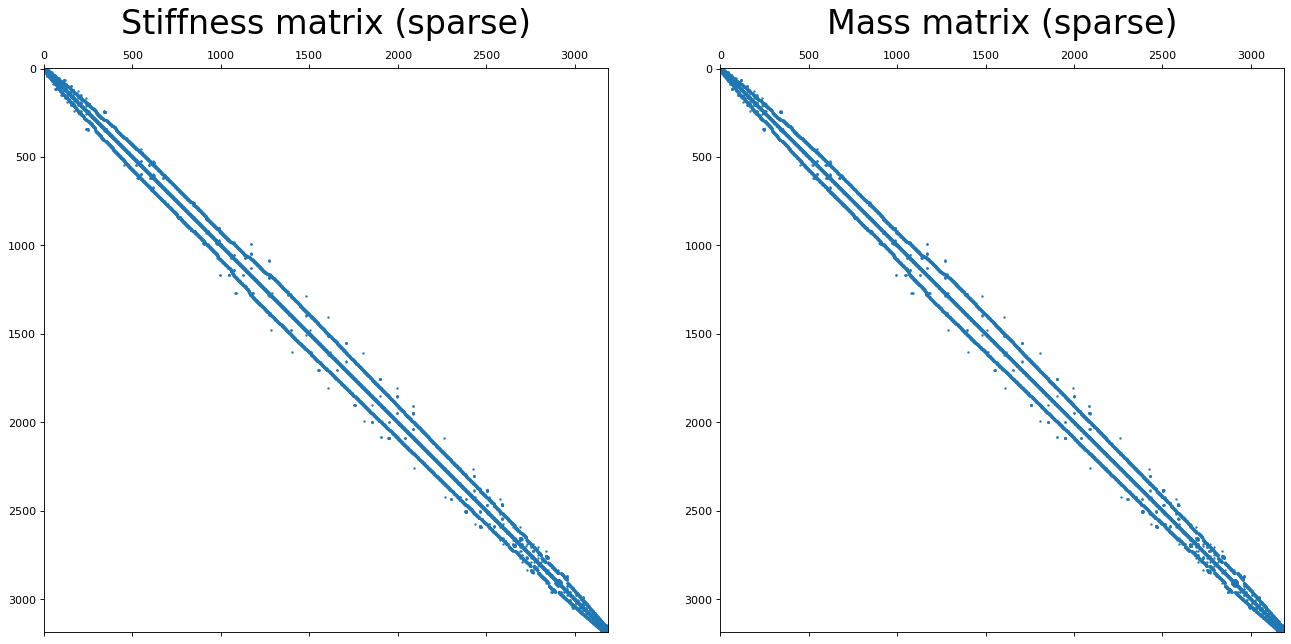

In [89]:
fig = plt.figure(figsize=(20, 10), dpi=80, facecolor="w", edgecolor="k")

if mass_matrix_sparse.shape[0] < 500:
    # Don't do this for large systems
    
    # Stiffness matrix
    plt.subplot(121)
    stiffness_matrix_dense = stiffness_matrix_sparse.todense()
    extremum = np.max(np.abs(stiffness_matrix_dense))
    plt.imshow(stiffness_matrix_dense, vmin=-extremum, vmax=extremum)
    plt.title("Stiffness matrix", size=30)
    plt.colorbar()
    
    # Mass matrix
    plt.subplot(122)
    mass_matrix_dense = mass_matrix_sparse.todense()
    extremum = np.max(np.abs(mass_matrix_dense))
    plt.imshow(mass_matrix_dense, vmin=0, vmax=extremum)
    plt.title("Mass matrix", size=30)
    plt.colorbar()
else:
    plt.subplot(121)
    plt.spy(stiffness_matrix_sparse, markersize=1)
    plt.title("Stiffness matrix (sparse)", size=30)
    plt.subplot(122)
    plt.spy(mass_matrix_sparse, markersize=1)
    plt.title("Mass matrix (sparse)", size=30)

We can now start to solve our PDE! As a first step, let's solve for ...

## Covariance functions and Green's functions

The covariance functions are not directly defined, only through the covariance operator. But investigating the covariance functions for a few points **is** very enlightening.

The definition of the covariance function is the following:
$$
\begin{align}
    (\mathcal{C} u) (\mathbf{x}) = \int_\Omega c(\mathbf{x}, \mathbf{x'} )\: u( \mathbf{x'} ) d \mathbf{x'}
\end{align}
$$
*That's a Green's function!*

Yup, and that makes investigating these rather 'easy'. We simply inject a dirac source into our elliptic PDE and let the FEM package compute the solution. What we see then is the **covariance function w.r.t. the injection point**.

Let's give it a try for a few different points.

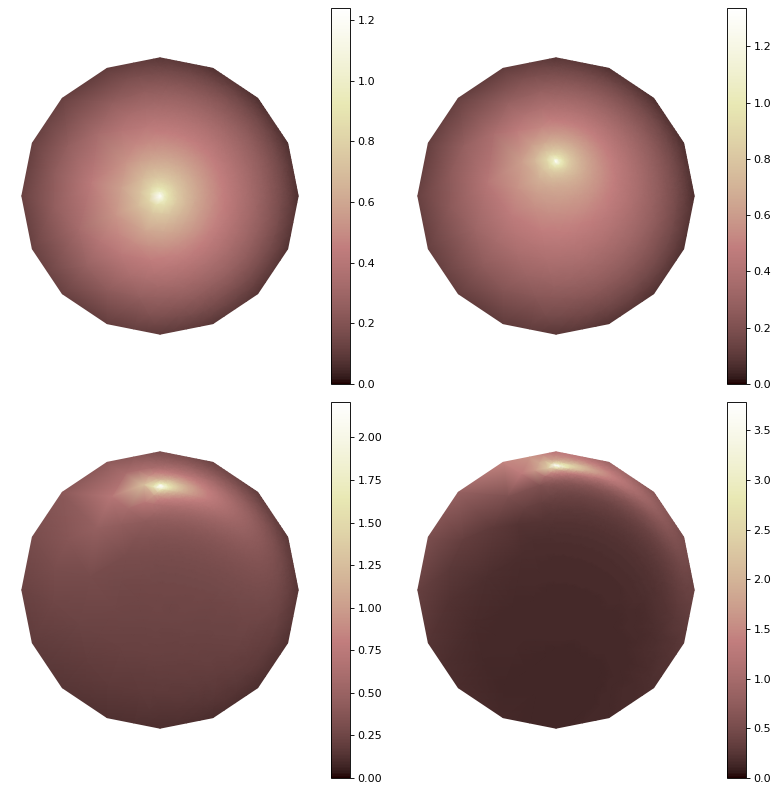

In [90]:
fig = plt.figure(figsize=(10, 10), dpi=80, facecolor="w", edgecolor="k")

# A few different Greens function source locations
y = [0, 0.25, 0.75, 0.9]

for i in range(y.__len__()):
    
    # Create the solution function
    solution = fenics.Function(V)
    
    # Create a new RHS vector for every solve.
    forcing_vector_copy = forcing_vector.copy()
    
    # Create the source (a Dirac Delta, for the Green's function)
    DiracSource = fenics.PointSource(V, fenics.Point(0.0, y[i]), 1.0)
    
    # Apply the dirac function to the forcing vector
    DiracSource.apply(forcing_vector_copy)
    
    # Solve the PDE 
    fenics.solve(stiffness_matrix, solution.vector(), forcing_vector_copy)

    # Compute values on mesh
    mesh_values = solution.compute_vertex_values(mesh)
    
    plt.subplot(int(y.__len__()/2), 2, i+1)
    plt.gca().set_aspect('equal')
    image = plt.tripcolor(mesh2triang(mesh), mesh_values, shading='gouraud', cmap=plt.get_cmap("pink"))
    image.set_clim(vmin=0) 
    plt.colorbar()
    plt.axis('off')
    
plt.tight_layout()

plt.show()

I think that the authors of [1] have created a very nice and useable prior using $\Theta$; we see that the covariance near the center of the domain looks like simple Gaussian blobs, while at the surface the response becomes very layered. Note however, that the **absolute value** of the Green's function increases (i.e. the variance), according to the authors as a result of the boundary condition. What this means for the prior is that we can expect larger variations at the surface. We could correct for this using a spatially varying $\alpha$.

## The good stuff: sample generation

Now, to generate samples we need to 'randomly' force the PDE. We can do this with scale-invariant Gaussian noise (I think this is called a Gaussian free field, GFF) as the right hand side. Now this may seem like an abstract thing, but what we do is use the FEM mass matrix $M$ as a covariance matrix. To now generate samples from random noise we need it's matrix square root $L$, s.t. $L^2 = M$. **This is the main expensive operation of GRFs!** I'm not sure how to avoid this operation. At least in the spectral element method, this is cheap, as $M$ would be diagonal. Generally, $L$ will **not** be cheap!

In [91]:
%%time
massSqrt = linalg.sqrtm(mass_matrix_sparse.todense())

CPU times: user 3min 59s, sys: 1min 8s, total: 5min 7s
Wall time: 26.4 s


In [92]:
%%time
operator = linalg.inv(stiffness_matrix_sparse.todense()) @ massSqrt

CPU times: user 39.9 s, sys: 2.15 s, total: 42.1 s
Wall time: 3.65 s


In [93]:
%%time
operator = spsolve(stiffness_matrix_sparse, massSqrt)

CPU times: user 1.52 s, sys: 420 ms, total: 1.94 s
Wall time: 1.27 s


CPU times: user 17min 2s, sys: 5min 30s, total: 22min 32s
Wall time: 1min 53s


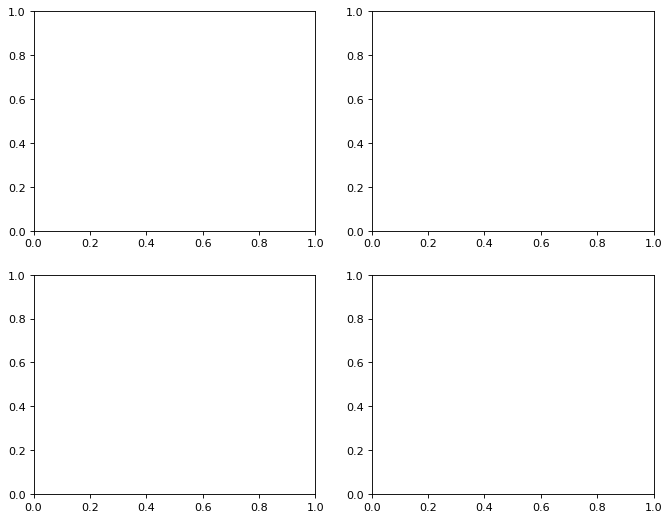

In [156]:
%%time 

# Create the sample function
sample = fenics.Function(V)

fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=80, facecolor="w", edgecolor="k")

axes = axes.flatten()

misfits1 = []
misfits2 = []

for i in range(10*500):
    for j in range(4):
        sample.vector().set_local(operator @ np.random.randn(operator.shape[0]))
        C = sample.compute_vertex_values(mesh)

        sample_vector = sample.vector().get_local()
        
        operator_applied_vector = stiffness_matrix_sparse @ sample_vector
        misfits1.append(np.linalg.norm(operator_applied_vector))
        misfits2.append(np.linalg.norm(mass_matrix_sparse @ operator_applied_vector))
        
#         axes[j].tripcolor(
#             mesh2triang(mesh),
#             C,
#             shading="gouraud",
#             cmap=plt.get_cmap("RdBu"),
#             vmin=-2,
#             vmax=2,
#         )
#         axes[j].set_aspect("equal")
#         axes[j].axis("off")

#     plt.tight_layout()
#     display.clear_output(wait=True)
#     display.display(plt.gcf())
# display.clear_output(wait=True)

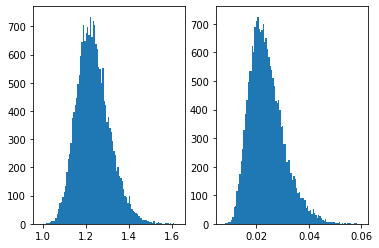

In [157]:
plt.subplot(1,2,1)
plt.hist(misfits1, 100);
plt.subplot(1,2,2)
plt.hist(misfits2, 100);

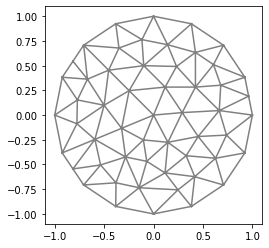

In [62]:
mesh_lowres = mshr.generate_mesh(domain, 5)
fenics.plot(mesh_lowres)

In [15]:
V_lowres = fenics.FunctionSpace(mesh_lowres, "CG", 1)
u_lowres = fenics.TrialFunction(V_lowres)
v_lowres = fenics.TestFunction(V_lowres)

# Theta and alpha remain unchanged, as they do no incorporate the function space or the mesh

# fenics.dx creates a domain integral, fenics.ds creates a surface integral
bilinear_component_lowres = (
    alpha
    * (
        fenics.dot(theta * fenics.grad(u_lowres), fenics.grad(v_lowres))
        + u_lowres * v_lowres
    )
    * fenics.dx
)
linear_component_lowres = fenics.Constant(0) * v_lowres * fenics.dx

In [16]:
stiffness_matrix_lowres, forcing_vector_lowres = fenics.assemble_system(
    bilinear_component_lowres, linear_component_lowres
)
mass_matrix_lowres = fenics.assemble(u_lowres * v_lowres * fenics.dx)

K_lowres = fenics.as_backend_type(stiffness_matrix_lowres).mat()
M_lowres = fenics.as_backend_type(mass_matrix_lowres).mat()

Ka, Kb, Kc = K_lowres.getValuesCSR()
stiffness_matrix_sparse_lowres = csr_matrix((Kc, Kb, Ka), K_lowres.size)
Ka, Kb, Kc, K = (None, None, None, None)  # Freeing up space

Ma, Mb, Mc = M_lowres.getValuesCSR()
mass_matrix_sparse_lowres = csr_matrix((Mc, Mb, Ma), M_lowres.size)
Ma, Mb, Mc, M = (None, None, None, None)  # Freeing up space

In [17]:
operator_lowres = linalg.inv(stiffness_matrix_sparse_lowres.todense()) @ linalg.sqrtm(mass_matrix_sparse_lowres.todense())

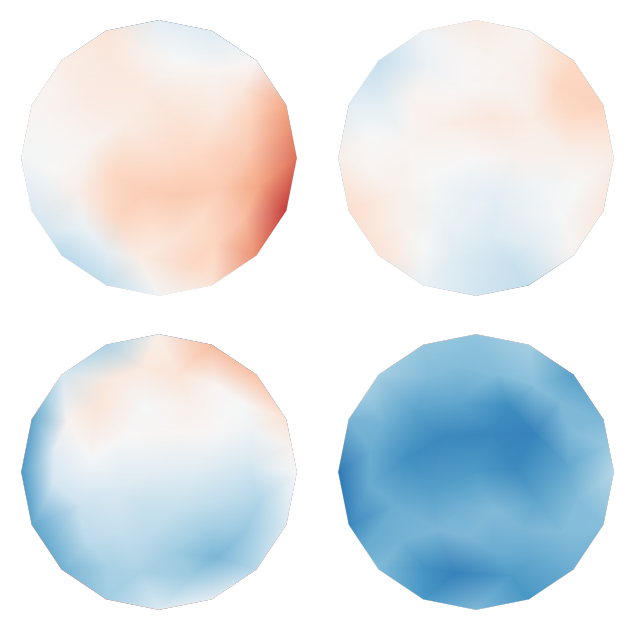

In [18]:
# Create the sample function
sample_lowres = fenics.Function(V_lowres)

fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=80, facecolor="w", edgecolor="k")

axes = axes.flatten()

for i in range(5):
    for j in range(4):

        plt.subplot(2, 2, j + 1)

        sample_lowres.vector().set_local(operator_lowres @ np.random.randn(operator_lowres.shape[0]))
        C_lowres = sample_lowres.compute_vertex_values(mesh_lowres)

        plt.tripcolor(
            mesh2triang(mesh_lowres),
            C_lowres,
            shading="gouraud",
            cmap=plt.get_cmap("RdBu"),
            vmin=-2,
            vmax=2,
        )
        plt.gca().set_aspect("equal")
        plt.axis("off")

    plt.tight_layout()
    display.clear_output(wait=True)
    display.display(plt.gcf());
display.clear_output(wait=True)